In [15]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from render_parameters import RenderParameters # Contains methods for setting up the SAS platform and scene
from utils import normalize, load_img_and_preprocess, c2g, g2c
from beamformer import Beamformer # Contains the beamformer
from waveform_processing import delay_waveforms # contains method for transmitting waveform to scene and match filtering

In [16]:
dev = 'cpu:0'
SIZE = 100 # simulation size

In [17]:
RP = RenderParameters(device=dev) # Main class that holds all the SAS parameters

RP.define_transducer_pos(theta_start=0, # transducer start angle
                         theta_stop=360, # transducer stop angle
                         theta_step=1,  # transducer step angle
                         r=0.85, # transducer radius (m)
                         z_TX=0.25, # transducer transmitter height (m)
                         z_RX=0.25) # transducer reciever height (m)

RP.define_scene_dimensions(scene_dim_x=[-.1, .1], # x dimensions
                          scene_dim_y=[-.1, .1], # y dimensions
                          scene_dim_z=[0, 0], # z dimensions
                          pix_dim_sim=[SIZE, SIZE, 1], # num pixels in each dimension for simulation
                          pix_dim_bf=[SIZE, SIZE, 1], # num pixels in each dimension for beamforming
                          perturb=False, # this parameter is disabled atm but used to perturb the scatterers
                          circle=True) # this code will break if you turn to False --- simulates scatterers in circular geometry

RP.generate_transmit_signal(crop_wfm=True) # generate the transmit signal and crop the number of samples using the scene dimensions to preserve memory

BF = Beamformer(RP=RP, interp='nearest', mp=False, r=100) # define the beamformer. mp turns multi-processing on/off for speed. r is the interpolation factor on nearest neighbor sampling.

(100, 100)


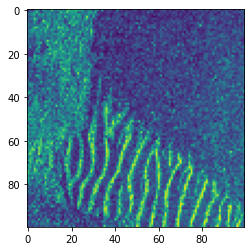

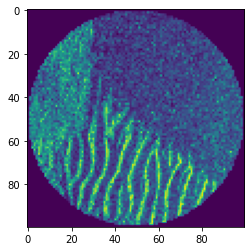

In [18]:
# Load and display ground truth scatterers
img_path = 'sassed_images/slc4.png'
gt_img = load_img_and_preprocess(img_path, SIZE)

plt.figure()
plt.imshow(gt_img)
plt.show()

# Crop out circular scatterers
gt_img = gt_img.ravel()[RP.circle_indeces] 
gt_img = normalize(gt_img)

plt.figure()
plt.imshow(c2g(gt_img, RP.circle_indeces, SIZE)) # c2g converts the circular indeces back to a grid for display purposes
plt.show()

In [19]:
# Simulate the measurements (this can be slow)
gt_img_tens = torch.from_numpy(gt_img).to(dev)
scat_phase = torch.zeros_like(gt_img_tens)#*(np.pi/2)

# note this method accepts tensors only
wfms = delay_waveforms(RP, 
                       RP.pixels_3D_sim, # pixel locations
                       gt_img_tens, # intensities
                       noise=False, # whether to add noise
                       noise_std=0., # noise std if adding noise
                       min_dist=RP.min_dist, # internally used for cropping the waveform
                       scat_phase=scat_phase) # phase of each scatterer

torch.Size([7668])


Beamforming no mp


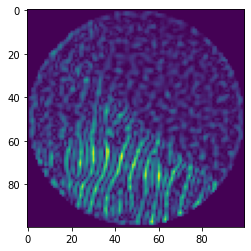

In [20]:
# Beamform the scene
complex_bf = BF.beamform(wfms, RP.pixels_3D_bf)
complex_bf = complex_bf.detach().cpu().numpy()

plt.figure()
plt.imshow(c2g(np.abs(complex_bf), RP.circle_indeces, SIZE))
plt.show()